<a href="https://colab.research.google.com/github/GOMTAE/INTRO2DL/blob/main/train_ped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Packages

In [2]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 16565 (delta 132), reused 100 (delta 69), pack-reused 16388
Receiving objects: 100% (16565/16565), 16.32 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (11893/11893), done.
fatal: not a git repository (or any of the parent directories): .git


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
from tensorflow import summary
import tensorflow as tf

In [4]:
# Basic python and ML Libraries
import os
import random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Module for Google Drive
from google.colab import drive

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files (not using this for our project, when reading xml files, it is good)
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor # We use FastRCNN
from torch.utils.data import Dataset, DataLoader

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
! pip install albumentations==0.4.6 # if you dont specify the version number in pip install, version 0.1.12 was installed which does not contain ToTensorV2.
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import re


     |████████████████████████████████| 122kB 8.5MB/s 
     |████████████████████████████████| 952kB 45.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=0fbe164a16dc4ab4bb7b52ae9b0d6009d449fefaaac30b480147c111cddaf801
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Import Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data_path = './drive/MyDrive/Dataset/Ped' #./drive/MyDrive/Path/To/Images/Which/Contains/Train/And/Test
model_dir = './drive/MyDrive/Codes/models'    #./drive/MyDrive/Path/To/Save/Your/Model
# defining the train directory and test directory
train_dir = './drive/MyDrive/Dataset/Ped/train'
test_dir = './drive/MyDrive/Dataset/Ped/test'

Construct Ped Dataset 

In [8]:
class PedDataset(Dataset):

    def __init__(self, train_dir, width, height, transforms=None):
        self.transforms = transforms
        self.train_dir = train_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be png
        self.imgs = [image for image in sorted(os.listdir(train_dir))
                        if image[-4:]=='.png']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Ped']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.train_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0

        # annotation file
        annot_filename = 'annot.txt'
        annot_file_path = os.path.join(self.train_dir, annot_filename)

        myfile = open(annot_file_path, "r")
        mylines = myfile.readlines()

        boxes = []
        labels = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        line = mylines[idx]
    
        regexp_pattern = '\([^\(\r\n]*\)'
        boxs = re.findall(regexp_pattern, line)
        for box in boxs:
          box = box.replace("(", "")
          box = box.replace(")", "")
          a = [int(s) for s in box.split(',')]
      
          # bounding box

          xmin = a[0]
          xmax = a[2]
            
          ymin = a[1]
          ymax = a[3]
            
          xmin_corr = (xmin/wt)*self.width
          xmax_corr = (xmax/wt)*self.width
          ymin_corr = (ymin/ht)*self.height
          ymax_corr = (ymax/ht)*self.height
            
          boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
          labels.append(1) # one box per picture # when reading picture with multiple boxes..
          
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        myfile.close()

        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = PedDataset(train_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index. (example)
img, target = dataset[15]
print(img.shape, '\n',target)

length of dataset =  400 

(224, 224, 3) 
 {'boxes': tensor([[ 80.2909,  28.3636, 143.1273, 173.8182]]), 'labels': tensor([1]), 'area': tensor([9139.8350]), 'iscrowd': tensor([0]), 'image_id': tensor([15])}


*   The dataset returns a tuple.
*   The first element is the image shape and the second element is a dictionary.
*   bounding boxes in the image which is evident from four lists in boxes and length of labels.

Visualization

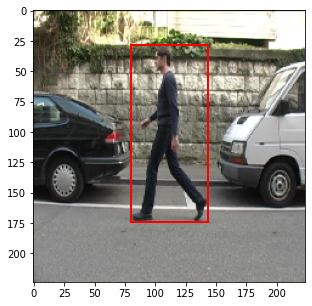

In [9]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    idx = 0
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none',
                                 )
        # Draw the bounding box on top of the image
        a.add_patch(rect)
        l = 'scores'
        if l in target.keys():
          score = target['scores'].cpu().tolist()
          plt.text(x, y, round(score[idx],4), color="red") # labels for prediction
        idx += 1
    plt.show()


# plotting the image with bboxes. Feel free to change the index
img, target = dataset[15]
plot_img_bbox(img, target)

Object detection model

In [10]:
def get_object_detection_model(num_classes):

    # load a pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

Augmentations

In [11]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                       # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Preparing dataset

In [12]:
# use our dataset and defined transformations
dataset = PedDataset(train_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = PedDataset(train_dir, 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Training

In [13]:
# to train on gpu if selected.
device = 'cuda'
print('Current Device : {}'.format(device))

num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Current Device : cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)           

Epoch: [0]  [ 0/32]  eta: 0:01:32  lr: 0.000166  loss: 0.0409 (0.0409)  loss_classifier: 0.0156 (0.0156)  loss_box_reg: 0.0184 (0.0184)  loss_objectness: 0.0050 (0.0050)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.8864  data: 0.8689  max mem: 7419
Epoch: [0]  [10/32]  eta: 0:00:45  lr: 0.001777  loss: 0.0339 (0.0363)  loss_classifier: 0.0142 (0.0144)  loss_box_reg: 0.0184 (0.0196)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0018 (0.0016)  time: 2.0821  data: 0.1005  max mem: 7419
Epoch: [0]  [20/32]  eta: 0:00:24  lr: 0.003389  loss: 0.0354 (0.0371)  loss_classifier: 0.0143 (0.0150)  loss_box_reg: 0.0190 (0.0198)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 2.0290  data: 0.0265  max mem: 7419
Epoch: [0]  [30/32]  eta: 0:00:04  lr: 0.005000  loss: 0.0380 (0.0370)  loss_classifier: 0.0159 (0.0150)  loss_box_reg: 0.0196 (0.0199)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 2.0215  data: 0.0288  max mem: 7419
Epoch: [

Save model

In [16]:
torch.save(model.state_dict(), os.path.join(model_dir, 'recent.pth'))

Decode prediction

In [18]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

Testing our Model

In [19]:
# pick one image from the test set
img, target = dataset_test[13]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))
print('predicted #scores: ', prediction['scores'].cpu().tolist())

predicted #boxes:  1
real #boxes:  1
predicted #scores:  [0.9933577179908752]


EXPECTED OUTPUT


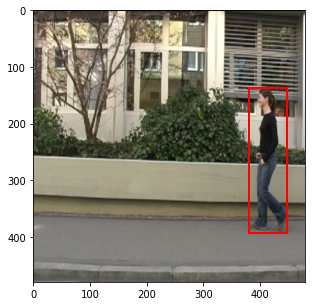

In [20]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


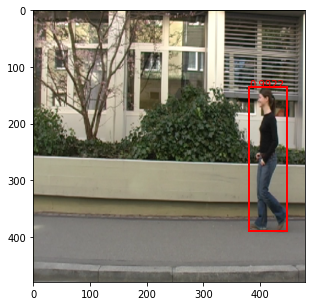

In [21]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


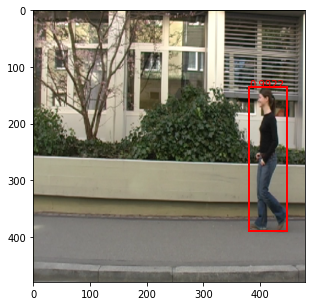

In [22]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

EXPECTED OUTPUT



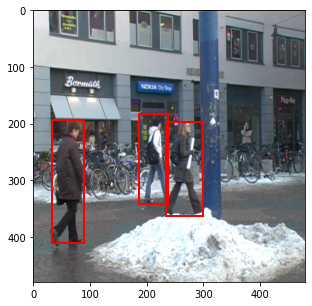

MODEL OUTPUT



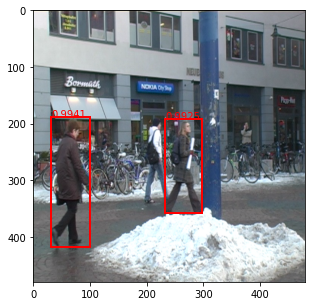

In [24]:
test_dataset = PedDataset(test_dir, 480, 480, transforms= get_transform(train=False))
# pick one image from the test set
img, target = test_dataset[15]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)